# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.64KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

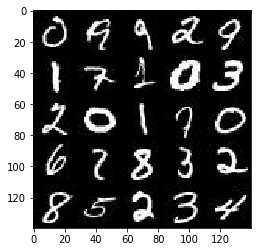

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

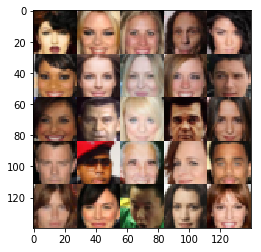

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    
    learn_rate = tf.placeholder(tf.float32)

    return real_input_images, z_input, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [36]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
#         x2 = tf.nn.dropout(x2, keep_prob=0.8)

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x2, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
#         x3 = tf.nn.dropout(x3, keep_prob=0.8)

        #Flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2

        #First fully connected layer
        y1 = tf.layers.dense(z, 7*7*512)

        #conv > batch_norm > leaky relu

        #Reshape to start the convolutional stack
        y1 = tf.reshape(y1, (-1, 7, 7, 512))
        y1 = tf.layers.batch_normalization(y1, training=is_train)
        y1 = tf.maximum(alpha * y1, y1)

        #2nd convolution
        y2 = tf.layers.conv2d_transpose(y1, 256, 5, strides=2, padding='same')
        y2 = tf.layers.batch_normalization(y2, training=is_train)
        y2 = tf.maximum(alpha * y2, y2)
#         y2 = tf.nn.dropout(y2, keep_prob=0.8)
        
        y3 = tf.layers.conv2d_transpose(y2, 128, 5, strides=2, padding='same')
        y3 = tf.layers.batch_normalization(y3, training=is_train)
        y3 = tf.maximum(alpha * y3, y3)
#         y3 = tf.nn.dropout(y3, keep_prob=0.8)
        
        logits = tf.layers.conv2d_transpose(y3, out_channel_dim, 3, strides=1, padding='same')
        
        out =tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [40]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - 0.1)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [43]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, z_input, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, z_input, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    
    saver = tf.train.Saver()
    
    steps = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, 
                             feed_dict={input_real: batch_images, z_input: batch_z, learn_rate: learning_rate})
                
                _ = sess.run(g_opt, 
                             feed_dict={input_real: batch_images, z_input: batch_z, learn_rate: learning_rate})
                
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_d_loss = d_loss.eval({z_input: batch_z, input_real: batch_images})
                    train_g_loss = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_d_loss),
                          "Generator Loss: {:.4f}".format(train_g_loss))
                    # Save losses to view after training
                    losses.append((train_d_loss, train_g_loss))

                if steps % 100 == 0:
                    # show samples
                    show_generator_output(sess, 16, z_input, image_channels, data_image_mode)
        
        saver.save(sess, './generator.ckpt')
        
        return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 0.5504... Generator Loss: 2.0690
Epoch 1/2... Discriminator Loss: 0.5466... Generator Loss: 2.0824
Epoch 1/2... Discriminator Loss: 0.4474... Generator Loss: 2.7770
Epoch 1/2... Discriminator Loss: 0.4247... Generator Loss: 2.9570
Epoch 1/2... Discriminator Loss: 0.4510... Generator Loss: 2.6930
Epoch 1/2... Discriminator Loss: 0.4320... Generator Loss: 2.8072
Epoch 1/2... Discriminator Loss: 0.3906... Generator Loss: 3.2009
Epoch 1/2... Discriminator Loss: 0.3454... Generator Loss: 4.5046
Epoch 1/2... Discriminator Loss: 0.3454... Generator Loss: 4.5692


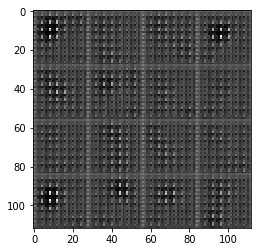

Epoch 1/2... Discriminator Loss: 0.6311... Generator Loss: 4.3181
Epoch 1/2... Discriminator Loss: 0.4030... Generator Loss: 3.1248
Epoch 1/2... Discriminator Loss: 0.4288... Generator Loss: 3.8539
Epoch 1/2... Discriminator Loss: 0.3533... Generator Loss: 3.9417
Epoch 1/2... Discriminator Loss: 0.4309... Generator Loss: 3.0634
Epoch 1/2... Discriminator Loss: 0.7377... Generator Loss: 2.4927
Epoch 1/2... Discriminator Loss: 0.7709... Generator Loss: 2.5268
Epoch 1/2... Discriminator Loss: 0.4702... Generator Loss: 2.4434
Epoch 1/2... Discriminator Loss: 0.7051... Generator Loss: 1.4154
Epoch 1/2... Discriminator Loss: 0.7168... Generator Loss: 1.3601


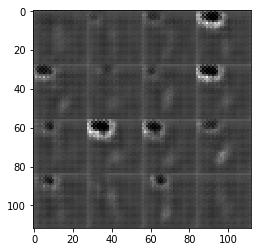

Epoch 1/2... Discriminator Loss: 0.7028... Generator Loss: 1.4295
Epoch 1/2... Discriminator Loss: 0.7304... Generator Loss: 1.3817
Epoch 1/2... Discriminator Loss: 0.7644... Generator Loss: 1.5818
Epoch 1/2... Discriminator Loss: 0.5122... Generator Loss: 2.2756
Epoch 1/2... Discriminator Loss: 0.5097... Generator Loss: 2.3950
Epoch 1/2... Discriminator Loss: 0.6268... Generator Loss: 1.8495
Epoch 1/2... Discriminator Loss: 0.6127... Generator Loss: 2.0057
Epoch 1/2... Discriminator Loss: 1.0182... Generator Loss: 1.2879
Epoch 1/2... Discriminator Loss: 0.8791... Generator Loss: 3.0253
Epoch 1/2... Discriminator Loss: 0.7168... Generator Loss: 1.3272


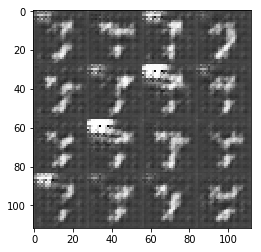

Epoch 1/2... Discriminator Loss: 0.5310... Generator Loss: 2.2607
Epoch 1/2... Discriminator Loss: 0.7543... Generator Loss: 1.3281
Epoch 1/2... Discriminator Loss: 0.7148... Generator Loss: 1.5254
Epoch 1/2... Discriminator Loss: 0.8129... Generator Loss: 1.5757
Epoch 1/2... Discriminator Loss: 0.8315... Generator Loss: 1.0684
Epoch 1/2... Discriminator Loss: 0.5106... Generator Loss: 2.7273
Epoch 1/2... Discriminator Loss: 0.6744... Generator Loss: 1.6343
Epoch 1/2... Discriminator Loss: 0.5790... Generator Loss: 1.7731
Epoch 1/2... Discriminator Loss: 0.5789... Generator Loss: 2.0334
Epoch 1/2... Discriminator Loss: 0.4143... Generator Loss: 2.9177


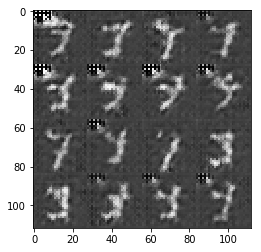

Epoch 1/2... Discriminator Loss: 0.4564... Generator Loss: 2.8517
Epoch 1/2... Discriminator Loss: 0.7414... Generator Loss: 1.2760
Epoch 1/2... Discriminator Loss: 0.9357... Generator Loss: 1.0281
Epoch 1/2... Discriminator Loss: 0.6213... Generator Loss: 1.7981
Epoch 1/2... Discriminator Loss: 0.7773... Generator Loss: 1.6704
Epoch 1/2... Discriminator Loss: 0.5547... Generator Loss: 2.2508
Epoch 1/2... Discriminator Loss: 0.6521... Generator Loss: 1.8124
Epoch 1/2... Discriminator Loss: 0.6015... Generator Loss: 1.6660
Epoch 1/2... Discriminator Loss: 0.4821... Generator Loss: 2.6065
Epoch 1/2... Discriminator Loss: 0.6003... Generator Loss: 1.8915


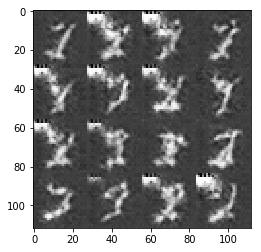

Epoch 1/2... Discriminator Loss: 0.5972... Generator Loss: 2.4031
Epoch 1/2... Discriminator Loss: 0.5461... Generator Loss: 2.6770
Epoch 1/2... Discriminator Loss: 0.8201... Generator Loss: 1.5870
Epoch 1/2... Discriminator Loss: 0.7014... Generator Loss: 1.6045
Epoch 1/2... Discriminator Loss: 0.6362... Generator Loss: 2.0563
Epoch 1/2... Discriminator Loss: 0.6828... Generator Loss: 2.2616
Epoch 1/2... Discriminator Loss: 1.5131... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 0.8598... Generator Loss: 1.1375
Epoch 1/2... Discriminator Loss: 0.7566... Generator Loss: 1.6226
Epoch 1/2... Discriminator Loss: 0.7247... Generator Loss: 2.0036


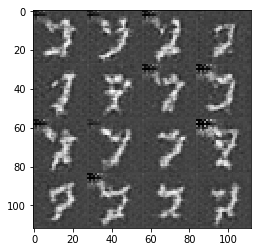

Epoch 1/2... Discriminator Loss: 0.6324... Generator Loss: 1.9271
Epoch 1/2... Discriminator Loss: 0.5881... Generator Loss: 2.1708
Epoch 1/2... Discriminator Loss: 0.6425... Generator Loss: 1.7028
Epoch 1/2... Discriminator Loss: 0.6626... Generator Loss: 1.6973
Epoch 1/2... Discriminator Loss: 0.8502... Generator Loss: 1.4837
Epoch 1/2... Discriminator Loss: 0.6314... Generator Loss: 1.7173
Epoch 1/2... Discriminator Loss: 0.7149... Generator Loss: 1.5916
Epoch 1/2... Discriminator Loss: 0.4996... Generator Loss: 2.5215
Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 1.4192
Epoch 1/2... Discriminator Loss: 2.5250... Generator Loss: 3.1722


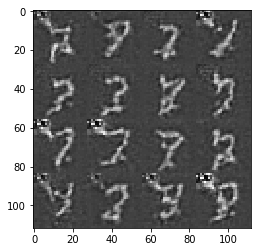

Epoch 1/2... Discriminator Loss: 0.8078... Generator Loss: 1.2569
Epoch 1/2... Discriminator Loss: 0.7759... Generator Loss: 1.6463
Epoch 1/2... Discriminator Loss: 0.7709... Generator Loss: 1.1994
Epoch 1/2... Discriminator Loss: 0.7238... Generator Loss: 1.3397
Epoch 1/2... Discriminator Loss: 0.6253... Generator Loss: 1.8543
Epoch 1/2... Discriminator Loss: 0.7811... Generator Loss: 1.2689
Epoch 1/2... Discriminator Loss: 0.6475... Generator Loss: 1.9820
Epoch 1/2... Discriminator Loss: 0.5767... Generator Loss: 3.4930
Epoch 1/2... Discriminator Loss: 0.5085... Generator Loss: 2.6040
Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 2.3792


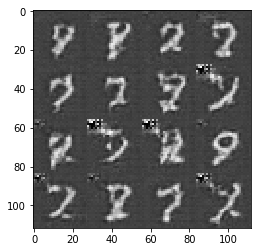

Epoch 1/2... Discriminator Loss: 0.6156... Generator Loss: 2.3688
Epoch 1/2... Discriminator Loss: 3.7449... Generator Loss: 4.2054
Epoch 1/2... Discriminator Loss: 0.8032... Generator Loss: 1.8357
Epoch 1/2... Discriminator Loss: 0.7950... Generator Loss: 1.2418
Epoch 1/2... Discriminator Loss: 1.0829... Generator Loss: 1.5934
Epoch 1/2... Discriminator Loss: 0.6236... Generator Loss: 1.7594
Epoch 1/2... Discriminator Loss: 0.6222... Generator Loss: 2.2354
Epoch 1/2... Discriminator Loss: 0.5295... Generator Loss: 2.1558
Epoch 1/2... Discriminator Loss: 0.5006... Generator Loss: 2.6058
Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 1.6212


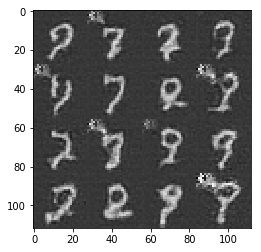

Epoch 1/2... Discriminator Loss: 0.8703... Generator Loss: 1.2796
Epoch 1/2... Discriminator Loss: 1.0612... Generator Loss: 0.8412
Epoch 1/2... Discriminator Loss: 0.7781... Generator Loss: 1.4776
Epoch 2/2... Discriminator Loss: 0.8122... Generator Loss: 1.6467
Epoch 2/2... Discriminator Loss: 0.6830... Generator Loss: 1.4885
Epoch 2/2... Discriminator Loss: 0.5737... Generator Loss: 2.5344
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.5163
Epoch 2/2... Discriminator Loss: 0.7459... Generator Loss: 1.2156
Epoch 2/2... Discriminator Loss: 0.6598... Generator Loss: 1.6706
Epoch 2/2... Discriminator Loss: 0.7494... Generator Loss: 2.0012


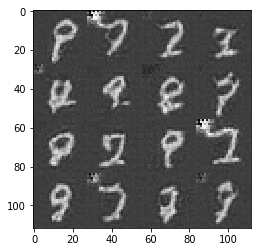

Epoch 2/2... Discriminator Loss: 0.6589... Generator Loss: 1.9859
Epoch 2/2... Discriminator Loss: 0.7626... Generator Loss: 1.2542
Epoch 2/2... Discriminator Loss: 0.8332... Generator Loss: 1.0850
Epoch 2/2... Discriminator Loss: 0.6181... Generator Loss: 1.7411
Epoch 2/2... Discriminator Loss: 0.5299... Generator Loss: 2.8666
Epoch 2/2... Discriminator Loss: 0.4919... Generator Loss: 2.4084
Epoch 2/2... Discriminator Loss: 0.6355... Generator Loss: 1.8478
Epoch 2/2... Discriminator Loss: 0.5836... Generator Loss: 2.5457
Epoch 2/2... Discriminator Loss: 2.0876... Generator Loss: 2.3436
Epoch 2/2... Discriminator Loss: 1.0140... Generator Loss: 1.6947


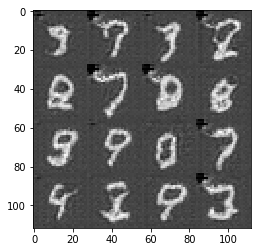

Epoch 2/2... Discriminator Loss: 1.0564... Generator Loss: 0.8896
Epoch 2/2... Discriminator Loss: 0.8364... Generator Loss: 2.0642
Epoch 2/2... Discriminator Loss: 0.5527... Generator Loss: 2.3731
Epoch 2/2... Discriminator Loss: 0.8875... Generator Loss: 1.2586
Epoch 2/2... Discriminator Loss: 0.7688... Generator Loss: 1.5086
Epoch 2/2... Discriminator Loss: 0.5357... Generator Loss: 1.8985
Epoch 2/2... Discriminator Loss: 0.7695... Generator Loss: 1.8370
Epoch 2/2... Discriminator Loss: 0.4977... Generator Loss: 2.5035
Epoch 2/2... Discriminator Loss: 0.6777... Generator Loss: 1.9902
Epoch 2/2... Discriminator Loss: 1.0419... Generator Loss: 1.8693


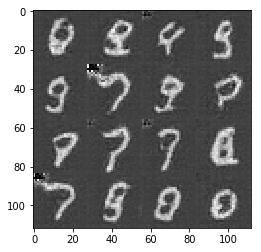

Epoch 2/2... Discriminator Loss: 0.5270... Generator Loss: 2.5115
Epoch 2/2... Discriminator Loss: 0.5364... Generator Loss: 2.7137
Epoch 2/2... Discriminator Loss: 0.4454... Generator Loss: 3.2013
Epoch 2/2... Discriminator Loss: 0.5607... Generator Loss: 3.3444
Epoch 2/2... Discriminator Loss: 0.8577... Generator Loss: 1.3579
Epoch 2/2... Discriminator Loss: 0.6146... Generator Loss: 1.6598
Epoch 2/2... Discriminator Loss: 0.6070... Generator Loss: 1.6994
Epoch 2/2... Discriminator Loss: 0.5917... Generator Loss: 2.1371
Epoch 2/2... Discriminator Loss: 0.8630... Generator Loss: 1.8176
Epoch 2/2... Discriminator Loss: 0.8106... Generator Loss: 1.2402


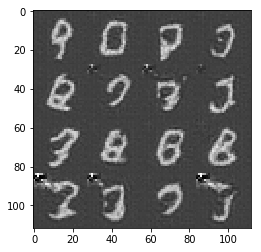

Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 0.7644
Epoch 2/2... Discriminator Loss: 1.1592... Generator Loss: 0.7381
Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 1.5835
Epoch 2/2... Discriminator Loss: 0.8370... Generator Loss: 1.4127
Epoch 2/2... Discriminator Loss: 0.8419... Generator Loss: 1.2340
Epoch 2/2... Discriminator Loss: 0.7311... Generator Loss: 1.5869
Epoch 2/2... Discriminator Loss: 0.6804... Generator Loss: 1.5737
Epoch 2/2... Discriminator Loss: 0.7514... Generator Loss: 1.5283
Epoch 2/2... Discriminator Loss: 0.7955... Generator Loss: 1.7213
Epoch 2/2... Discriminator Loss: 0.6593... Generator Loss: 3.1042


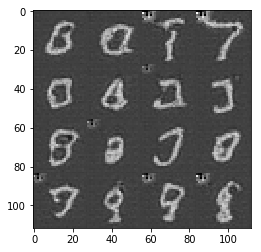

Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 2.6467
Epoch 2/2... Discriminator Loss: 0.7756... Generator Loss: 1.3410
Epoch 2/2... Discriminator Loss: 0.6153... Generator Loss: 1.9282
Epoch 2/2... Discriminator Loss: 0.6963... Generator Loss: 1.7142
Epoch 2/2... Discriminator Loss: 0.4493... Generator Loss: 3.0886
Epoch 2/2... Discriminator Loss: 0.7334... Generator Loss: 1.8358
Epoch 2/2... Discriminator Loss: 0.6526... Generator Loss: 1.9444
Epoch 2/2... Discriminator Loss: 0.6379... Generator Loss: 2.0305
Epoch 2/2... Discriminator Loss: 4.8057... Generator Loss: 5.7142
Epoch 2/2... Discriminator Loss: 0.9980... Generator Loss: 1.1753


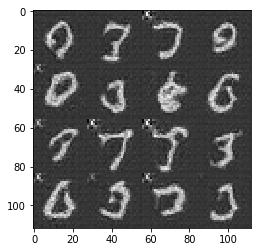

Epoch 2/2... Discriminator Loss: 0.8504... Generator Loss: 1.4030
Epoch 2/2... Discriminator Loss: 0.8883... Generator Loss: 1.4033
Epoch 2/2... Discriminator Loss: 0.8389... Generator Loss: 1.2551
Epoch 2/2... Discriminator Loss: 0.6178... Generator Loss: 1.7743
Epoch 2/2... Discriminator Loss: 0.7064... Generator Loss: 1.8424
Epoch 2/2... Discriminator Loss: 0.5753... Generator Loss: 2.0449
Epoch 2/2... Discriminator Loss: 0.6561... Generator Loss: 1.5524
Epoch 2/2... Discriminator Loss: 0.4976... Generator Loss: 3.2363
Epoch 2/2... Discriminator Loss: 0.6341... Generator Loss: 2.2274
Epoch 2/2... Discriminator Loss: 0.5816... Generator Loss: 1.8988


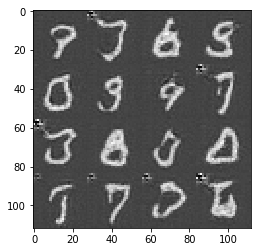

Epoch 2/2... Discriminator Loss: 0.5868... Generator Loss: 1.7684
Epoch 2/2... Discriminator Loss: 0.6126... Generator Loss: 2.7882
Epoch 2/2... Discriminator Loss: 0.6206... Generator Loss: 1.9763
Epoch 2/2... Discriminator Loss: 0.5621... Generator Loss: 2.0509
Epoch 2/2... Discriminator Loss: 0.6459... Generator Loss: 1.6851
Epoch 2/2... Discriminator Loss: 0.7382... Generator Loss: 1.8488
Epoch 2/2... Discriminator Loss: 0.5081... Generator Loss: 2.3652
Epoch 2/2... Discriminator Loss: 0.6454... Generator Loss: 1.5855
Epoch 2/2... Discriminator Loss: 0.6844... Generator Loss: 1.6413
Epoch 2/2... Discriminator Loss: 0.5011... Generator Loss: 3.7899


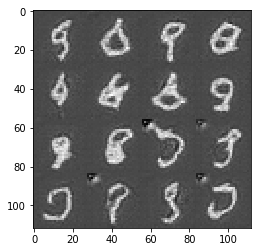

Epoch 2/2... Discriminator Loss: 0.8372... Generator Loss: 2.6274
Epoch 2/2... Discriminator Loss: 0.7981... Generator Loss: 1.3997
Epoch 2/2... Discriminator Loss: 0.6554... Generator Loss: 1.8658
Epoch 2/2... Discriminator Loss: 0.5692... Generator Loss: 3.7871
Epoch 2/2... Discriminator Loss: 0.5852... Generator Loss: 3.1668
Epoch 2/2... Discriminator Loss: 0.6927... Generator Loss: 3.3244
Epoch 2/2... Discriminator Loss: 1.0322... Generator Loss: 1.8256
Epoch 2/2... Discriminator Loss: 0.8694... Generator Loss: 1.7390
Epoch 2/2... Discriminator Loss: 0.9043... Generator Loss: 1.1334
Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 0.8783


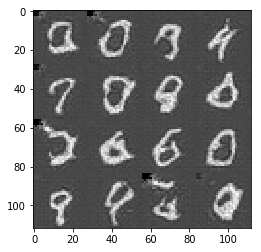

Epoch 2/2... Discriminator Loss: 0.7063... Generator Loss: 1.6610
Epoch 2/2... Discriminator Loss: 0.8107... Generator Loss: 1.5433
Epoch 2/2... Discriminator Loss: 0.7520... Generator Loss: 1.5711
Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 1.6046
Epoch 2/2... Discriminator Loss: 0.7284... Generator Loss: 1.3904
Epoch 2/2... Discriminator Loss: 0.5888... Generator Loss: 2.3225
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 1.2955


In [44]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 1.7925
Epoch 1/1... Discriminator Loss: 0.4375... Generator Loss: 2.5326
Epoch 1/1... Discriminator Loss: 0.3750... Generator Loss: 3.3980
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 3.8146
Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 4.5781
Epoch 1/1... Discriminator Loss: 0.3526... Generator Loss: 4.4858
Epoch 1/1... Discriminator Loss: 0.3541... Generator Loss: 4.3660
Epoch 1/1... Discriminator Loss: 0.3420... Generator Loss: 4.8377
Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 4.9565


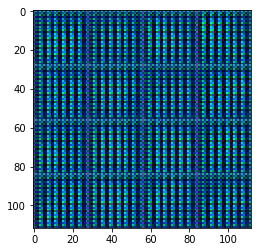

Epoch 1/1... Discriminator Loss: 0.3381... Generator Loss: 4.9010
Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 5.3453
Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 5.5800
Epoch 1/1... Discriminator Loss: 0.3386... Generator Loss: 5.7058
Epoch 1/1... Discriminator Loss: 0.3310... Generator Loss: 5.9393
Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 6.1357
Epoch 1/1... Discriminator Loss: 0.3304... Generator Loss: 6.1683
Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 6.2871
Epoch 1/1... Discriminator Loss: 0.3298... Generator Loss: 6.3015
Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 6.2417


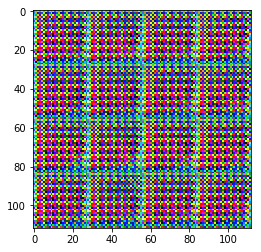

Epoch 1/1... Discriminator Loss: 0.3320... Generator Loss: 5.9926
Epoch 1/1... Discriminator Loss: 0.3299... Generator Loss: 6.1886
Epoch 1/1... Discriminator Loss: 0.3285... Generator Loss: 6.3814
Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 6.4429
Epoch 1/1... Discriminator Loss: 0.3303... Generator Loss: 6.5423
Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 6.5693
Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 6.6021
Epoch 1/1... Discriminator Loss: 0.3293... Generator Loss: 6.6231
Epoch 1/1... Discriminator Loss: 0.3288... Generator Loss: 6.5661
Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 6.2655


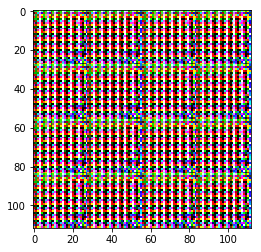

Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 6.3478
Epoch 1/1... Discriminator Loss: 0.3278... Generator Loss: 6.6177
Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 6.3117
Epoch 1/1... Discriminator Loss: 0.3287... Generator Loss: 6.4040
Epoch 1/1... Discriminator Loss: 0.3284... Generator Loss: 6.6107
Epoch 1/1... Discriminator Loss: 0.3285... Generator Loss: 6.4951
Epoch 1/1... Discriminator Loss: 0.3321... Generator Loss: 6.6342
Epoch 1/1... Discriminator Loss: 0.3281... Generator Loss: 6.6033
Epoch 1/1... Discriminator Loss: 0.3311... Generator Loss: 6.7925
Epoch 1/1... Discriminator Loss: 0.3273... Generator Loss: 7.2024


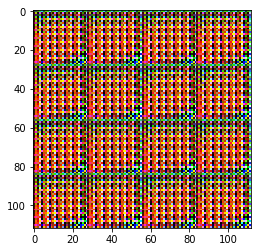

Epoch 1/1... Discriminator Loss: 0.3274... Generator Loss: 7.1386
Epoch 1/1... Discriminator Loss: 0.3276... Generator Loss: 6.9954
Epoch 1/1... Discriminator Loss: 0.3275... Generator Loss: 6.8786
Epoch 1/1... Discriminator Loss: 0.3292... Generator Loss: 6.1643
Epoch 1/1... Discriminator Loss: 0.3298... Generator Loss: 5.8733
Epoch 1/1... Discriminator Loss: 9.8755... Generator Loss: 4.5146
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.5979
Epoch 1/1... Discriminator Loss: 0.5657... Generator Loss: 1.8223
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 1.0510


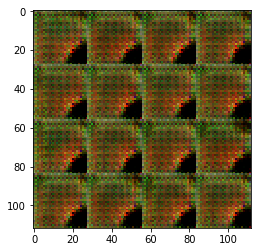

Epoch 1/1... Discriminator Loss: 0.5248... Generator Loss: 1.9304
Epoch 1/1... Discriminator Loss: 0.4898... Generator Loss: 2.6036
Epoch 1/1... Discriminator Loss: 1.6242... Generator Loss: 0.4357
Epoch 1/1... Discriminator Loss: 0.6026... Generator Loss: 1.7164
Epoch 1/1... Discriminator Loss: 2.5478... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 0.5489... Generator Loss: 2.0603
Epoch 1/1... Discriminator Loss: 0.6497... Generator Loss: 2.3226
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 1.4063
Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 2.2072
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.4232


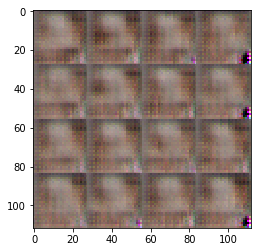

Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 1.6461
Epoch 1/1... Discriminator Loss: 0.7854... Generator Loss: 1.3515
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.7303
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 2.0948
Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 1.3675
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.8948
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 2.5641
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 2.0364
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 1.7775
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.2419


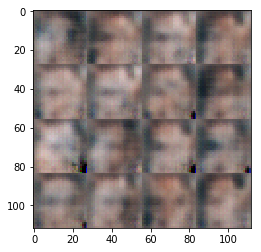

Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.7414
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.3389
Epoch 1/1... Discriminator Loss: 1.6443... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 1.7044
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.3939
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.3473
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 1.5662
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.3868
Epoch 1/1... Discriminator Loss: 0.8399... Generator Loss: 1.3097
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.2173


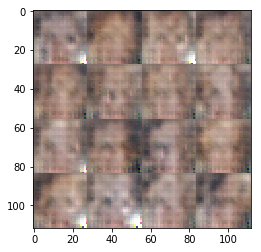

Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.4386
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.2085
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.8076
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 1.3551
Epoch 1/1... Discriminator Loss: 0.7732... Generator Loss: 1.5059
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.1220
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.6308... Generator Loss: 0.4207


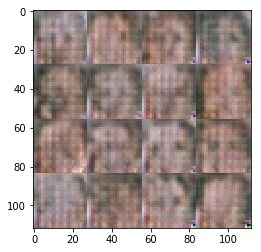

Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 1.2539
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 1.0960
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.3054
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 1.3927
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.2239
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 1.0865


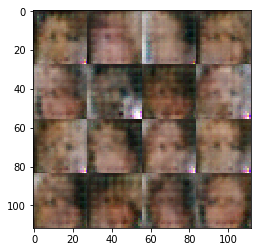

Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 2.0143
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 1.2653
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 1.8453
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 1.9578
Epoch 1/1... Discriminator Loss: 0.7655... Generator Loss: 1.4969
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 1.1029
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 1.2468
Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 1.7061
Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 2.9876


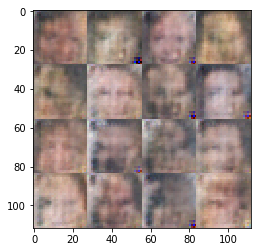

Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.1267
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 1.0928
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 1.6119
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 1.6547
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.8132


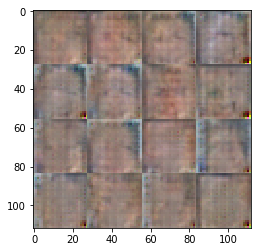

Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 1.4513


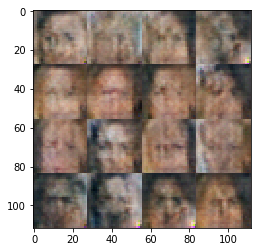

Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 1.1488
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 0.6430... Generator Loss: 1.5862
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.7307


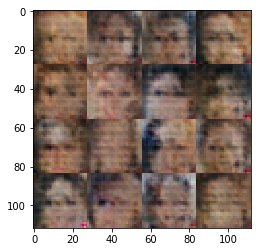

Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 1.4036
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 1.5154
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 3.1724
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 1.2174
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.6604
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 1.9951
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 1.2343


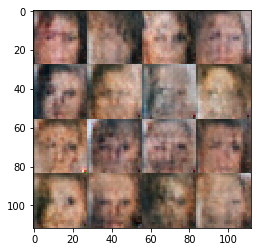

Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 2.6006
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.8530
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 1.3401
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.0040
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 0.9823


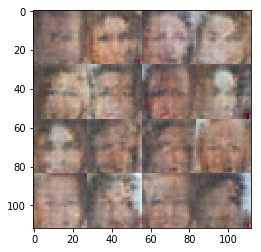

Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 2.2557... Generator Loss: 0.3129
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 1.3668


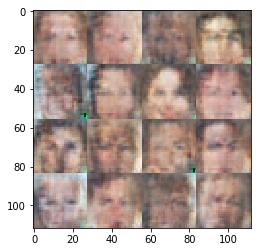

Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.5849
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.4467
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 0.7065... Generator Loss: 3.4340
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 1.8160
Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 2.1148
Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 2.2873


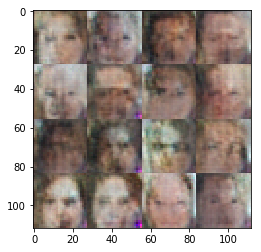

Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 1.2760
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 1.4400
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 1.2338
Epoch 1/1... Discriminator Loss: 0.5561... Generator Loss: 2.4606
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 3.1925
Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 2.9847
Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 2.1391
Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 1.0841
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.9513


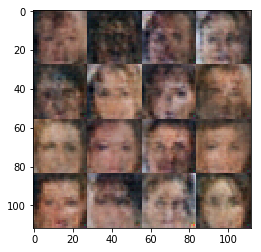

Epoch 1/1... Discriminator Loss: 1.7289... Generator Loss: 0.3254
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.6035... Generator Loss: 0.3939
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 2.6693
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 1.1743
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 0.6923... Generator Loss: 3.2114
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 0.5502... Generator Loss: 2.3944
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 1.1192


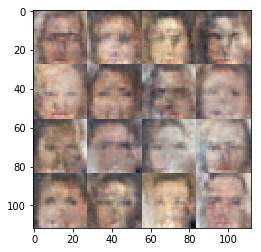

Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 2.4231
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.5081
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 1.3263
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 2.7459
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 1.3771
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7143


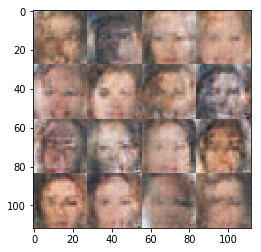

Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 0.5297... Generator Loss: 2.3220
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 0.6820... Generator Loss: 3.6608
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.9444


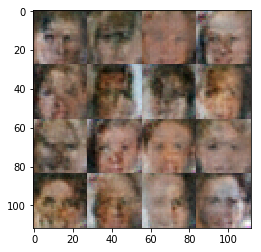

Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.6754... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.6544... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.5857... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.6640


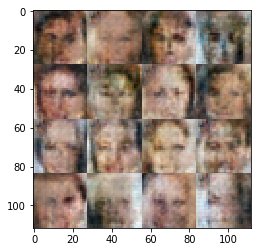

Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8173


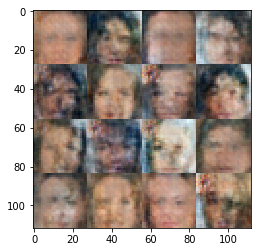

Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7034


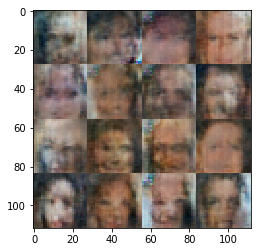

Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7834


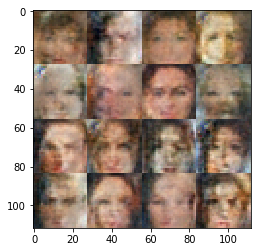

Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7489


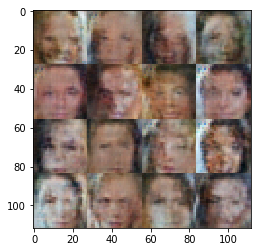

Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.8853


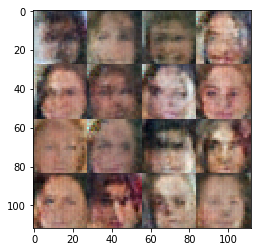

Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.8315


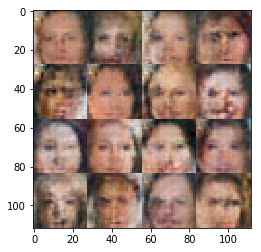

Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7535


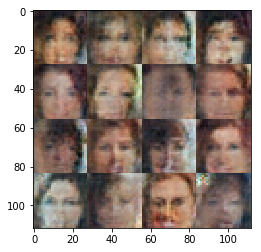

Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.5757... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.7098


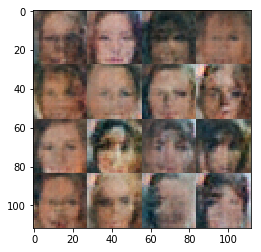

Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.6432... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7568


In [45]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.